 # Visualización

 ## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display


 ## Settings

In [2]:
sns.set()
sns.set_context('notebook', font_scale=1.3, rc={'lines.linewidth': 2})
plot_width = 12
plot_height = 8


 ## Lectura del fichero de datos con conversión a timedelta

In [3]:
file = '.\\data\\utmb.2.csv'
print(file)
df = pd.read_csv(file, low_memory=False)
# todo uncomment
# display(df[:3])

cronos = list(df)[9:]
for crono in cronos:
    td = pd.to_timedelta(df[crono])
    df[crono] = td


.\data\utmb.2.csv


 ## Visualización de datos

 #### Después de tantas horas de trabajo todavía no hemos visto ni un gráfico; ha llegado el momento ```seaborn```. Comencemos por ver la evolución del número de participantes por año mostrando los que consiguieron acabar la carrera. Recordemos que para 2010 no disponemos de datos de llegada, así que lo excluimos.

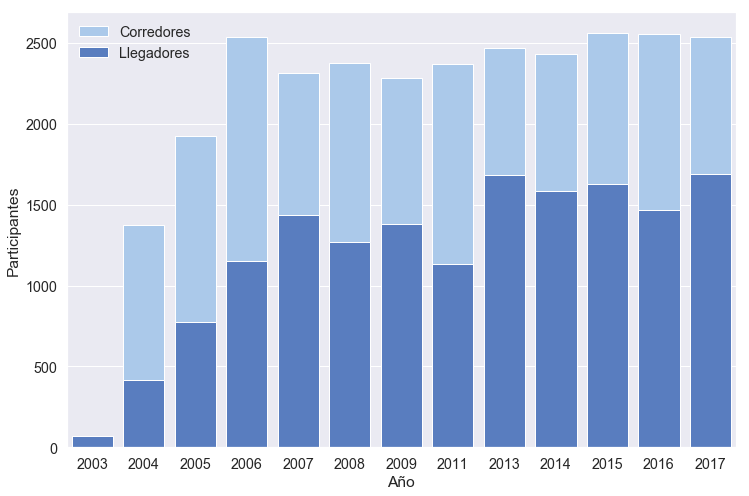

In [4]:
fdf = df[df.Year != 2010]

runners = pd.DataFrame(fdf.groupby('Year')['Id'].count())
runners.rename(columns={'Id': 'Runners'}, inplace=True)
runners.reset_index(level=0, inplace=True)

finishers = pd.DataFrame(
    fdf.loc[df.Arrivee.notna()].groupby('Year')['Id'].count())
finishers.rename(columns={'Id': 'Finishers'}, inplace=True)
finishers.reset_index(level=0, inplace=True)

f, ax = plt.subplots(figsize=(plot_width, plot_height))

sns.set_color_codes("pastel")
sns.barplot(data=runners, x='Year', y='Runners',
            label="Corredores", color='b')

sns.set_color_codes("muted")
sns.barplot(data=finishers, x='Year', y='Finishers',
            label="Llegadores", color='b')

ax.set(xlabel='Año', ylabel='Participantes')
ax.legend(ncol=1, loc="upper left", frameon=False)


 #### Vemos que el primer año acabaron todos, probablemente habría más participantes pero el dataset que tenemos de ese año debe ser exclusivamente de los que acabaron. El 2014 apenas llegó un tercio de los corredores y el 2015 y 2016 menos de la mitad. En el resto de los años no se aprecia un patrón regular. Tendríamos que intentar averiguar la causa.

 #### La gráfica del tiempo de los vencedores se muestra abajo.

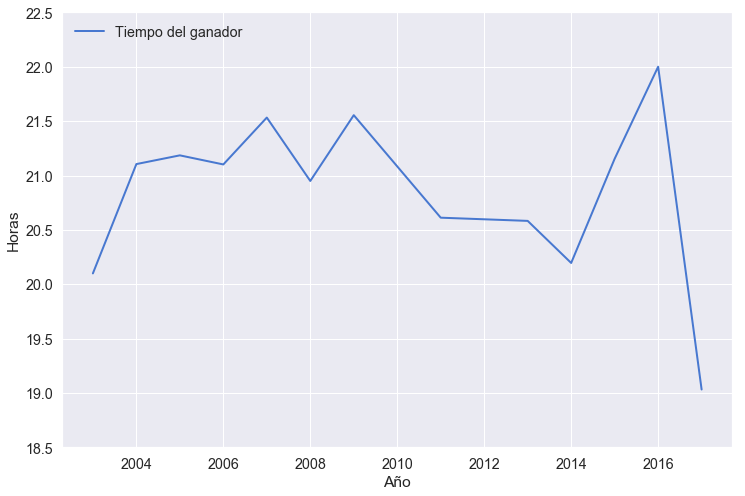

In [5]:
winners = pd.DataFrame(fdf.groupby('Year')['Arrivee'].min().dropna())
winners.reset_index(level=0, inplace=True)
winners['Hours'] = winners.Arrivee / np.timedelta64(1, 'h')

f, ax = plt.subplots(figsize=(plot_width, plot_height))

# sns.set_color_codes("pastel")
sns.lineplot(data=winners, x='Year', y='Hours',
             label="Tiempo del ganador", color='b')
ax.set_ylim(18.5, 22.5)

ax.set(xlabel='Año', ylabel='Horas')
ax.legend(ncol=1, loc="upper left", frameon=False)


 #### El tiempo de 2003 es el segundo más rápido, sorprende un poco; en aquellos años las carreras de montaña estaban comenzando y los participantes eran aficionados. Con corredores profesionales no se bajó el tiempo hasta 14 años después, no parece creíble. Es más plausible que después de la primera edición se hiciera una modificación del recorrido.

 #### ¿Estarán relacionados el tiempo de carrera con el porcentaje de corredores que acaban la carrera? En una carrera que discurre a más de 2.000 m de altura en casi todo su recorrido, es posible que las condiciones climatológicas y el estado del terreno influyan en la velocidad de carrera. Veámoslo, toca apartar 2003 de este análisis ya que no hay datos de no finalizadores.

[Text(0, 0.5, 'Horas'), Text(0.5, 0, '% finalizadores')]

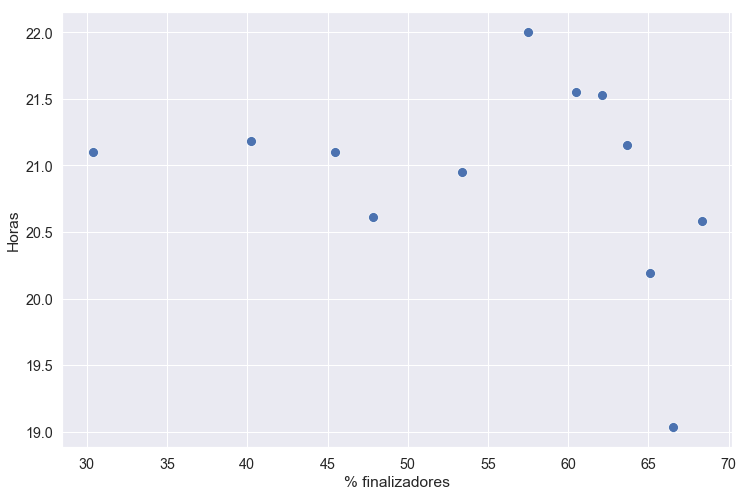

In [6]:
# unimos los tres dataframes
merged1 = pd.merge(winners, runners)
merged1 = pd.merge(merged1, finishers)
# calculamos el porcentaje de finalizadores
merged1['FinishersPerc'] = merged1.Finishers / merged1.Runners * 100
# excluimos 2003
merged1 = merged1[merged1.Year != 2003]
# mostramos el plot
f, ax = plt.subplots(figsize=(plot_width, plot_height))

sns.scatterplot(data=merged1, x="FinishersPerc", y="Hours",
                s=100)

ax.set(xlabel='% finalizadores', ylabel='Horas')


 #### Si observamos los puntos a la derecha del 55% vemos una correlación negativa: a mayor porcentaje de finalizadores mejor tiempo de carrera. Pero estamos mirando solamente el tiempo de los ganadores, vamos a extender el estudio a la media de tiempo de todos los que llegaron.

[Text(0, 0.5, 'Horas'), Text(0.5, 0, '% finalizadores')]

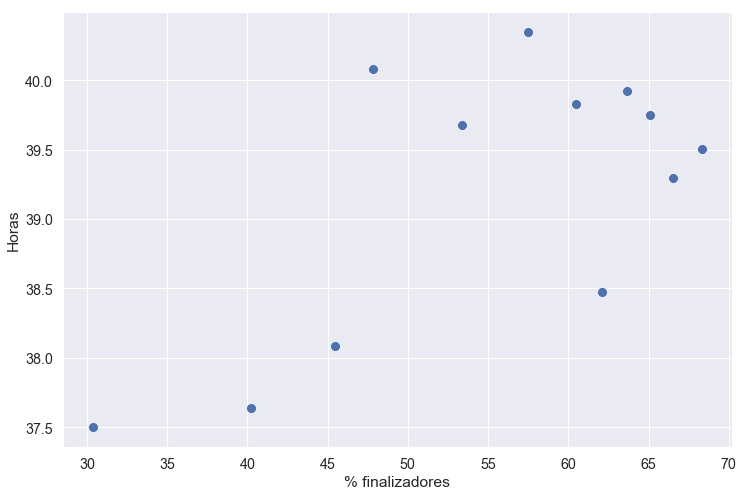

In [7]:
# construimos un dataframe con la suma de los tiempos de llegada
total_time = pd.DataFrame(
    fdf.loc[df.Arrivee.notna()].groupby('Year')['Arrivee'].sum())
total_time.rename(columns={'Arrivee': 'TotalTime'}, inplace=True)
# calculamos las horas totales
total_time['TotalHours'] = total_time.TotalTime / np.timedelta64(1, 'h')
# pasamos year de índice a columna
total_time.reset_index(level=0, inplace=True)
# 2003 desde total_time se queda fuera del merge automáticamente
merged2 = pd.merge(merged1, total_time)
# hallamos la media de los que llegaron
merged2['AvgFinishersTime'] = merged2.TotalHours / merged2.Finishers

# mostramos el plot
f, ax = plt.subplots(figsize=(plot_width, plot_height))

sns.scatterplot(data=merged2, x="FinishersPerc", y="AvgFinishersTime", s=100)

ax.set(xlabel='% finalizadores', ylabel='Horas')


 #### Bueno, se observa una tendencia creciente, puede decirse que, en general, a mayor porcentaje de finalizadores la media de horas por finalizador aumenta. La correlación entre las series es 0.67:

In [8]:
merged3 = merged2[['FinishersPerc', 'AvgFinishersTime']]
corr = merged3.corr()
corr


FinishersPerc  AvgFinishersTime
FinishersPerc          1.000000          0.673284
AvgFinishersTime       0.673284          1.000000

 #### Usando ```jointplots``` la correlación se ve así.

Text(20.625, 0.5, 'Horas')

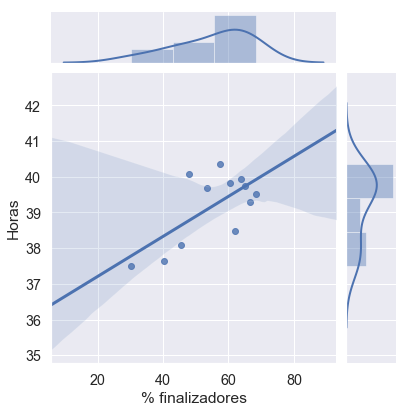

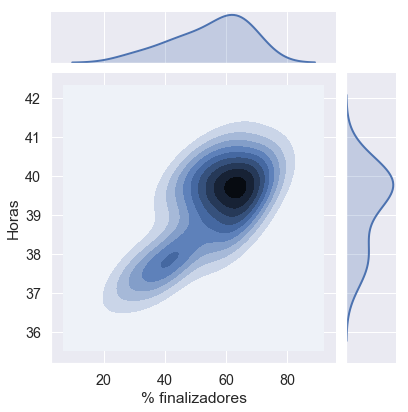

In [9]:
j = sns.jointplot(data=merged2, x='FinishersPerc',
                  y='AvgFinishersTime', kind='reg')
j.ax_joint.set_xlabel('% finalizadores')
j.ax_joint.set_ylabel('Horas')

j = sns.jointplot(data=merged2, x='FinishersPerc',
                  y='AvgFinishersTime', kind='kde')
j.ax_joint.set_xlabel('% finalizadores')
j.ax_joint.set_ylabel('Horas')


 #### Curiosamente con el tipo ```kde``` se forma la figura de la huella de un píe, pero no diremos que es una conclusión científica ;-)

 #### Aprovechamos para ver la evolución del tiempo medio de los que acabaron la carrera.

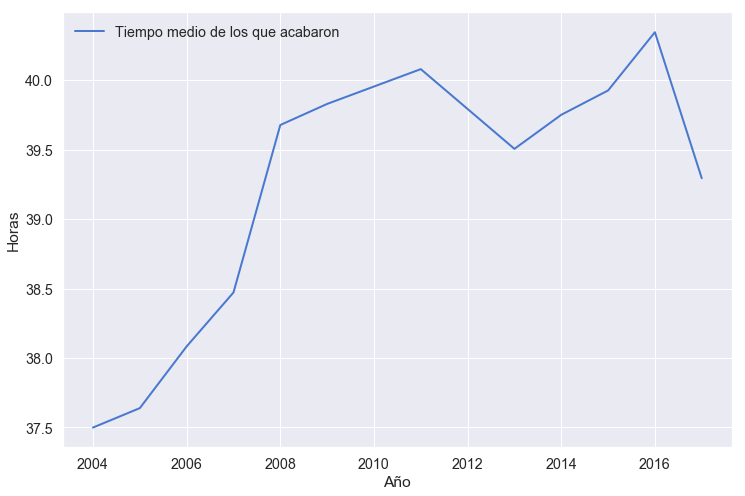

In [10]:
f, ax = plt.subplots(figsize=(plot_width, plot_height))

sns.lineplot(data=merged2, x='Year', y='AvgFinishersTime',
             label="Tiempo medio de los que acabaron", color='b')

ax.set(xlabel='Año', ylabel='Horas')
ax.legend(ncol=1, loc="upper left", frameon=False)


 #### Vemos que en la evolución del tiempo medio de los que acabaron la carrera se observa una tendencia alcista hasta 2011, cuando comienza a oscilar.

 #### En cuanto a los participantes por país, la presencia de franceses es abrumadora. Mostramos dos gráficos para facilitar la visualización. Hacemos el estudio sobre el dataframe completo recuperando el año 2010 ya que no tratamos tiempos.

Country  Quantity
1       fr      7938
2       es      1591
3       it      1116
4       gb       888
5       jp       560
6       de       470
7       ch       427
8       us       313
9       be       305
10      pl       244

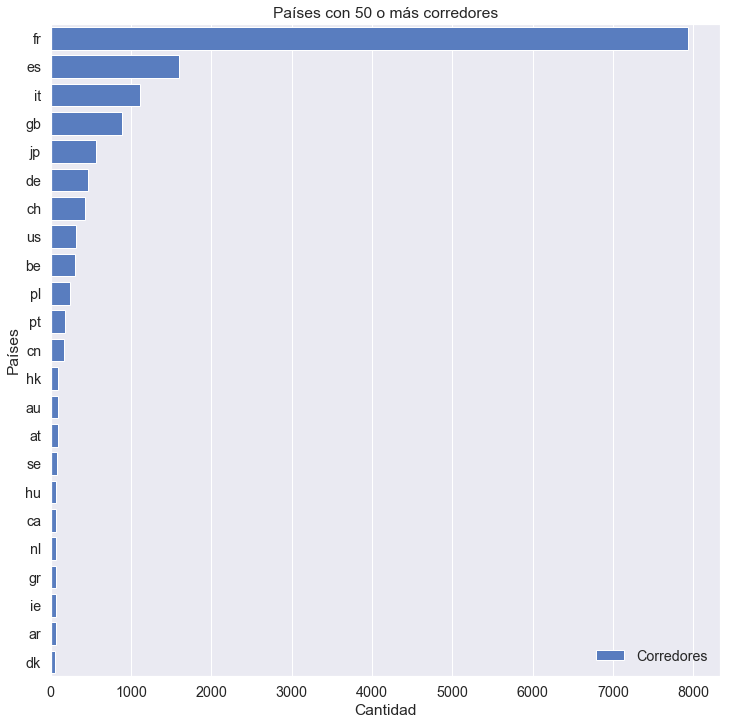

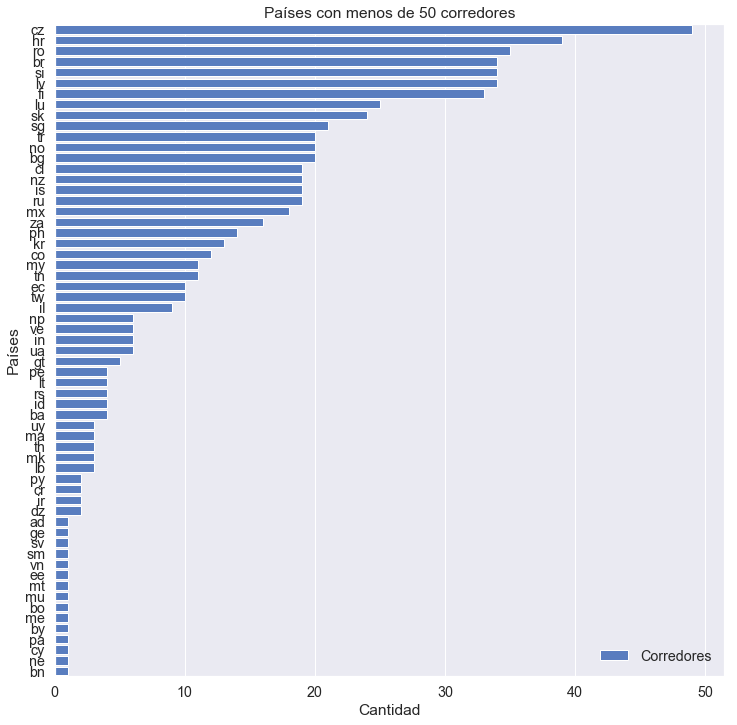

In [11]:
# contamos los países por orden descendente
countries = pd.DataFrame(df.groupby('Nationality')[
                         'Nationality'].count().sort_values(ascending=False))
# arreglamos el nombre de la columna cantidad
countries.rename(columns={'Nationality': 'Quantity'}, inplace=True)
# pasamos el índice a la columna Country
countries.reset_index(level=0, inplace=True)
countries.rename(columns={'Nationality': 'Country'}, inplace=True)
# eliminamos los países con código ' ' como habíamos advertido antes
countries = countries.loc[countries.Country != ' ']
# mostramos los primeros
display(countries[:10])

# separamos en dos partes los países para una mejor visualización
countries_above = countries.loc[countries.Quantity >= 50]
countries_below = countries.loc[countries.Quantity < 50]

# generamos el plot
f, ax = plt.subplots(figsize=(plot_width, plot_width))

sns.barplot(data=countries_above, x='Quantity', y='Country',
            label="Corredores", color='b')

ax.set(title='Países con 50 o más corredores',
       xlabel='Cantidad', ylabel='Países')
ax.legend(ncol=1, loc="lower right", frameon=False)

f, ax = plt.subplots(figsize=(plot_width, plot_width))

sns.barplot(data=countries_below, x='Quantity', y='Country',
            label="Corredores", color='b')

ax.set(title='Países con menos de 50 corredores',
       xlabel='Cantidad', ylabel='Países')
ax.legend(ncol=1, loc="lower right", frameon=False)


 #### Comprobemos qué pasa con la participación por sexo.

Sex  Year    f     h
0    2003    7    60
1    2004  112  1264
2    2005  170  1752
3    2006  191  2344
4    2007  174  2140
5    2008  172  2204
6    2009  179  2107
7    2010  183  2312
8    2011  186  2182
9    2013  223  2245
10   2014  199  2232
11   2015  222  2339
12   2016  257  2297
13   2017  242  2293

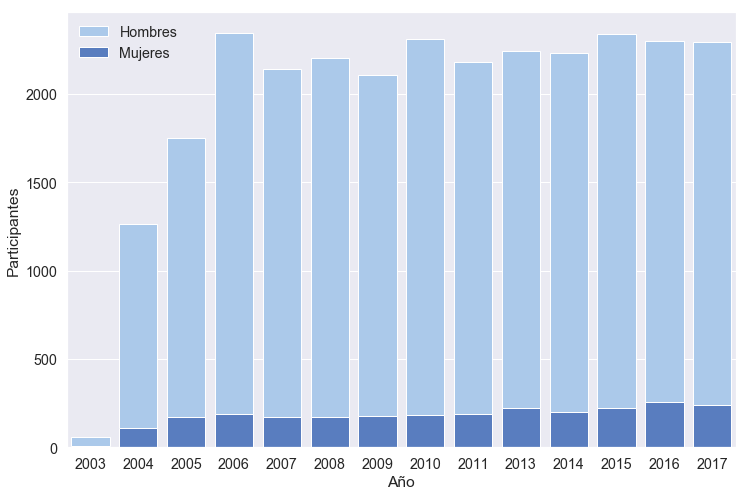

In [12]:
# recuperamos los datos agrupados mediante pivot table
sex_df = df.pivot_table('Id', index='Year', columns='Sex', aggfunc='count')
# pasamos el índice a columna
sex_df.reset_index(level=0, inplace=True)
display(sex_df)

# dibujamos
f, ax = plt.subplots(figsize=(plot_width, plot_height))

sns.set_color_codes("pastel")
sns.barplot(data=sex_df, x='Year', y='h',
            label="Hombres", color='b')

sns.set_color_codes("muted")
sns.barplot(data=sex_df, x='Year', y='f',
            label="Mujeres", color='b')

ax.set(xlabel='Año', ylabel='Participantes')
ax.legend(ncol=1, loc="upper left", frameon=False)


 #### Vaya, la participación de chicas ronda solo el 10% aproximadamente de manera estable. Revisemos el rendimiento de las chicas vs los chicos.

c:\python\37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.


Year           tf            th         mf         mh   cf    ch  \
0   2003   236.369722   1874.443333  29.639722  20.099444    7    60   
1   2004   773.693333  14900.995833  26.148333  21.105000   20   398   
2   2005  1856.300833  27238.700833  26.897500  21.185278   48   725   
3   2006  2788.019722  41084.151944  25.372222  21.101667   71  1081   
4   2007  3839.655000  51444.203611  25.395833  21.532778   95  1342   
5   2008  3334.990000  46976.211667  25.328056  20.949722   81  1187   
6   2009  4162.703056  50921.174167  24.933611  21.555000  101  1282   
7   2011  2889.620000  42520.846389  25.033333  20.611944   72  1061   
8   2013  5705.119722  60901.707778  22.623889  20.582500  140  1546   
9   2014  4639.177500  58246.916667  23.388889  20.195556  114  1468   
10  2015  5345.621111  59774.143889  25.259167  21.154167  132  1499   
11  2016  5371.433056  53856.251944  25.261111  22.000556  131  1337   
12  2017  5843.896389  60446.015556  25.778611  19.031667  147  1540   

           af         ah         at  
0   33.767103  31.240722  31.504672  
1   38.684667  37.439688  37.499256  
2   38.672934  37.570622  37.639071  
3   39.267883  38.005691  38.083482  
4   40.417421  38.333982  38.471718  
5   41.172716  39.575578  39.677604  
6   41.214882  39.720105  39.829268  
7   40.133611  40.076198  40.079847  
8   40.750855  39.393084  39.505829  
9   40.694539  39.677736  39.751008  
10  40.497130  39.876013  39.926281  
11  41.003306  40.281415  40.345834  
12  39.754397  39.250659  39.294554

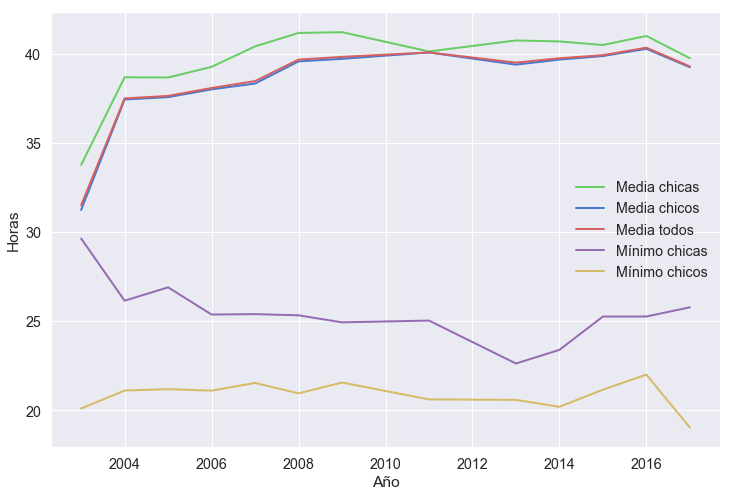

In [13]:
# recuperamos los tiempos sumados, los mínimos y contamos los participantes con pivot table
times_sex_df = fdf.pivot_table('Arrivee', index='Year', columns='Sex',
                               aggfunc=[np.sum, np.min, 'count'])
# renombramos la columnas por conveniencia
cols = ['tf', 'th', 'mf', 'mh', 'cf', 'ch']
times_sex_df.columns = cols
# pasamos el timedelta a horas
times_sex_df.tf = times_sex_df.tf / np.timedelta64(1, 'h')
times_sex_df.th = times_sex_df.th / np.timedelta64(1, 'h')
times_sex_df.tt = times_sex_df.th + times_sex_df.tf
times_sex_df.mf = times_sex_df.mf / np.timedelta64(1, 'h')
times_sex_df.mh = times_sex_df.mh / np.timedelta64(1, 'h')

# hallamos la media
times_sex_df['af'] = times_sex_df.tf / times_sex_df.cf
times_sex_df['ah'] = times_sex_df.th / times_sex_df.ch
times_sex_df['at'] = times_sex_df.tt / (times_sex_df.ch + times_sex_df.cf)

# pasamos el índice a columna
times_sex_df.reset_index(level=0, inplace=True)
display(times_sex_df)

# dibujamos la diferencia
f, ax = plt.subplots(figsize=(plot_width, plot_height))

sns.lineplot(data=times_sex_df, x='Year', y='af',
             label="Media chicas", color='g')
sns.lineplot(data=times_sex_df, x='Year', y='ah',
             label="Media chicos", color='b')
sns.lineplot(data=times_sex_df, x='Year', y='at',
             label="Media todos", color='r')
sns.lineplot(data=times_sex_df, x='Year', y='mf',
             label="Mínimo chicas", color='m')
sns.lineplot(data=times_sex_df, x='Year', y='mh',
             label="Mínimo chicos", color='y')

ax.set(xlabel='Año', ylabel='Horas')
ax.legend(ncol=1, loc='best', frameon=False)


 #### ¡Bueno!, pocas, pero matonas, la diferencia en los últimos tres años ronda la media hora y en el 2011 hablamos de minutos. Destaca también que la media de todos los corredores está muy influenciada por la gran diferencia de participación entre chicos y chicas, siendo casi paralela a la de los primeros. Por otra parte, es remarcable la distancia por sexos entre ganadores y entre las medias: el global de las chicas se aproxima al de los chicos, pero entre los números uno las líneas están mucho más separadas.

 #### En cuanto a la evolución comparada de las categorías se ve que el patrón de participantes es casi clónico en los últimos años.

c:\python\37\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


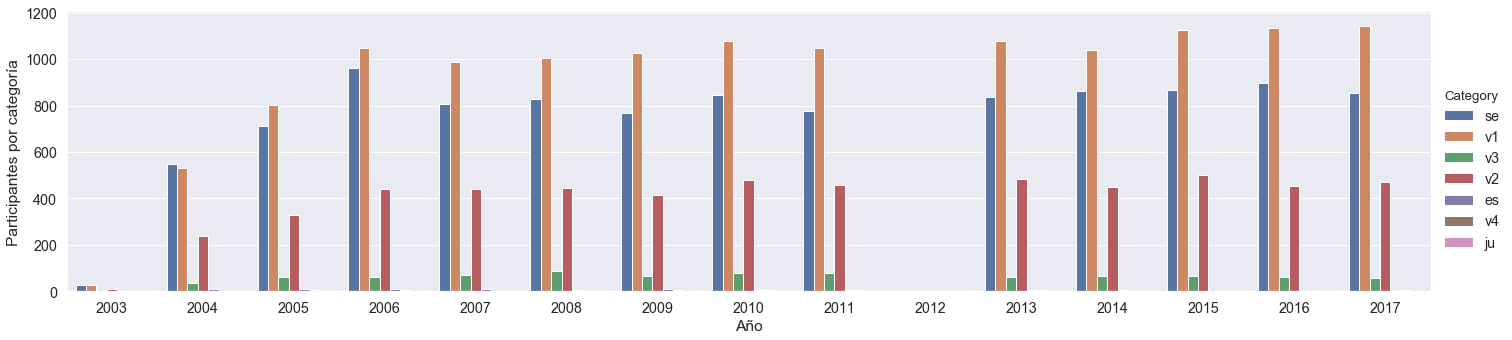

In [14]:
# Usamos un factor table muy conveniente en este caso
g = sns.factorplot("Year", data=df, aspect=4.0, kind='count',
                   hue='Category', order=range(2003, 2018))
g.set_xlabels('Año')
g.set_ylabels('Participantes por categoría')


 #### En cuanto a la evolución comparada de las categorías se ve que el patrón de participantes es casi clónico en los últimos años.

 #### Para poder ver la evolución en cada punto de paso de los n primeros corredores de cada carrera se ha definido una función auxiliar que acepta como parámetros el año deseado y el número de corredores –aunque, por claridad, no se recomienda poner más de 10-. La función es capaz de generar los puntos de paso dinámicamente, mostrando los correspondientes a cada año. Lanzamos la ejecución para 10 corredores chicos y chicas. Recordemos que para 2003 no había etapas, por eso se muestran líneas rectas. En ningún caso se ven grandes remontadas.

c:\python\37\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


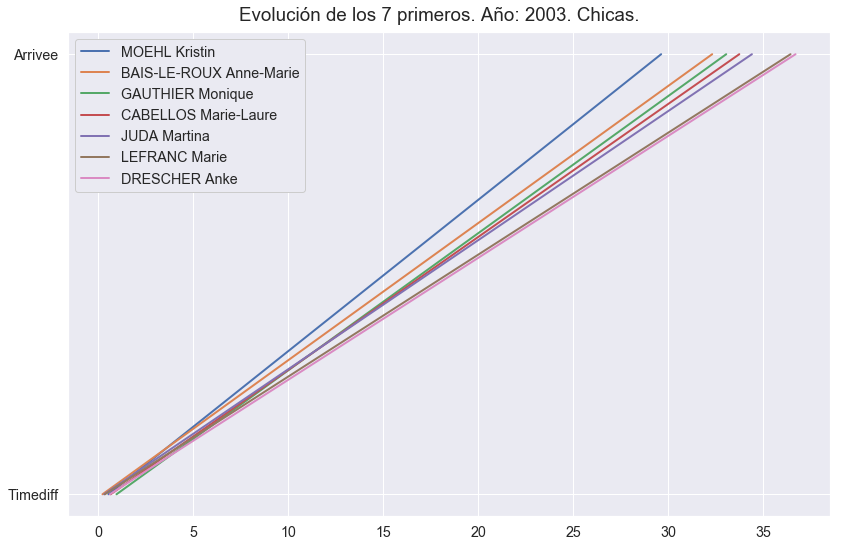

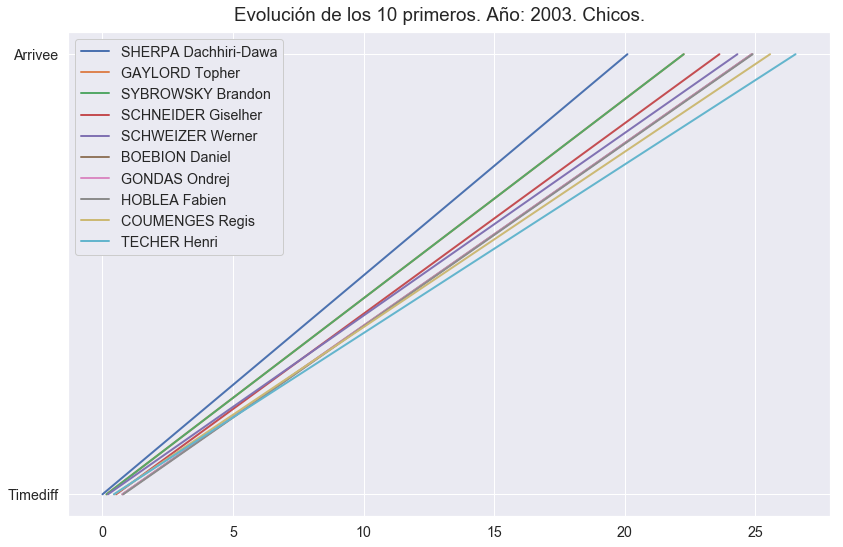

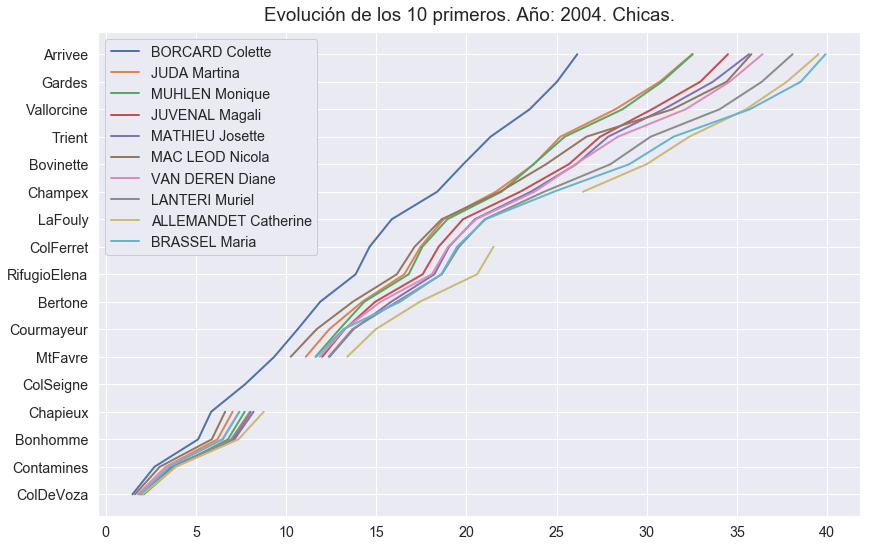

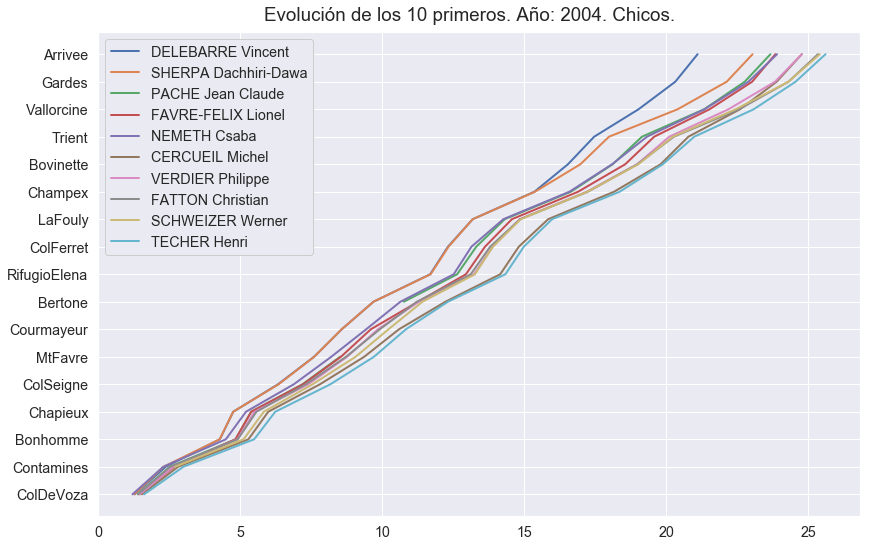

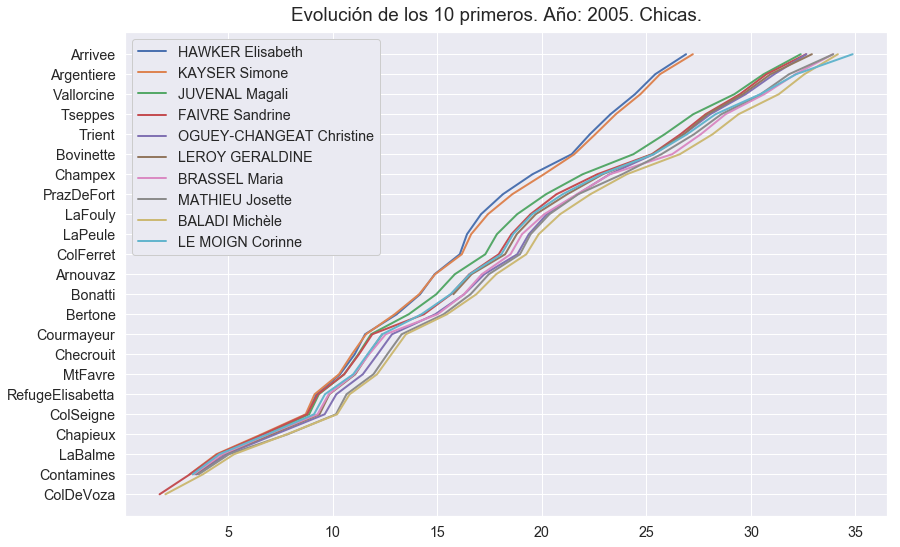

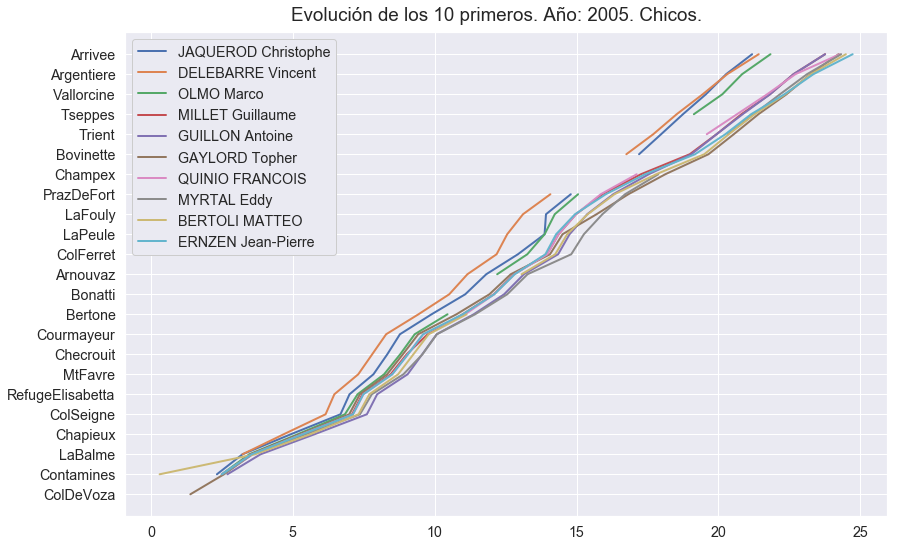

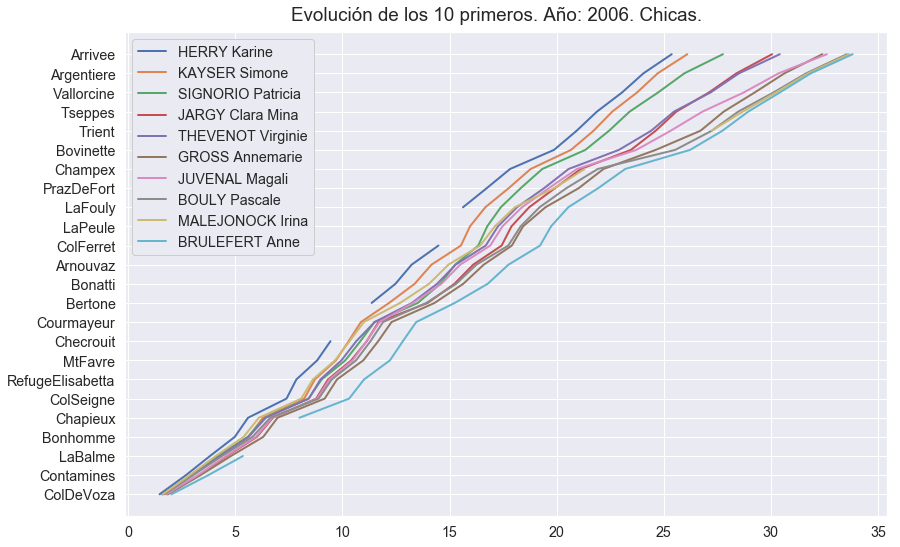

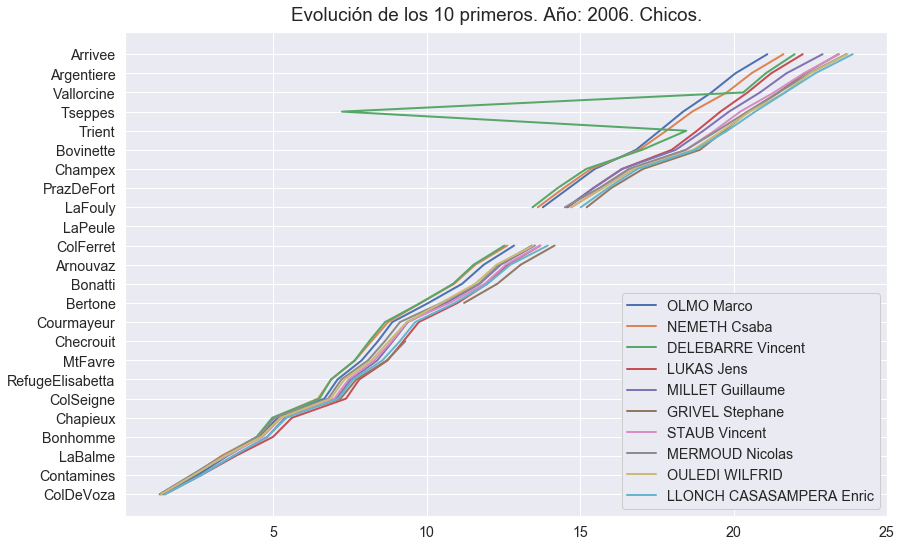

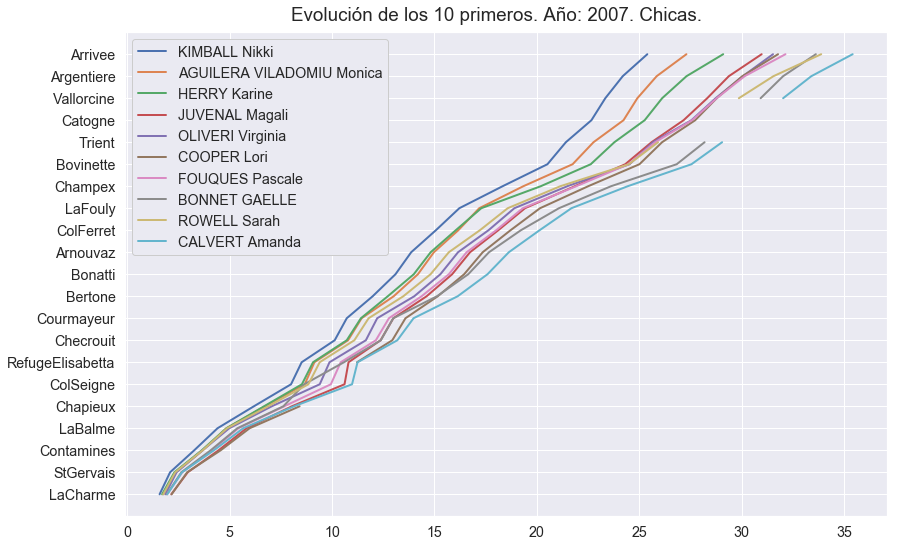

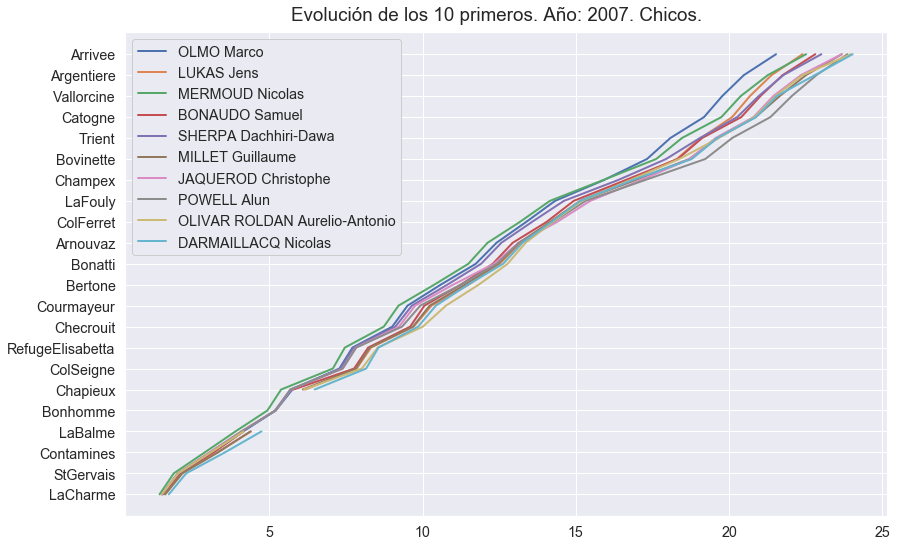

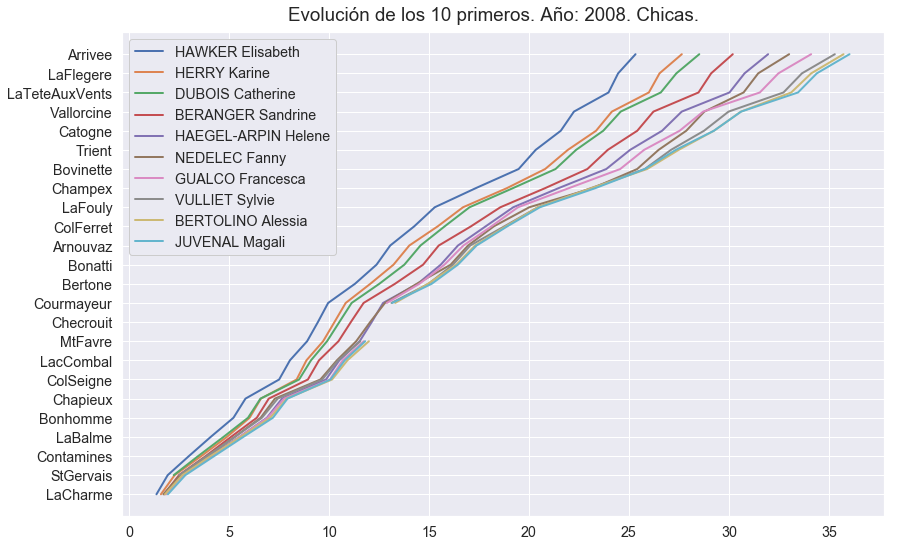

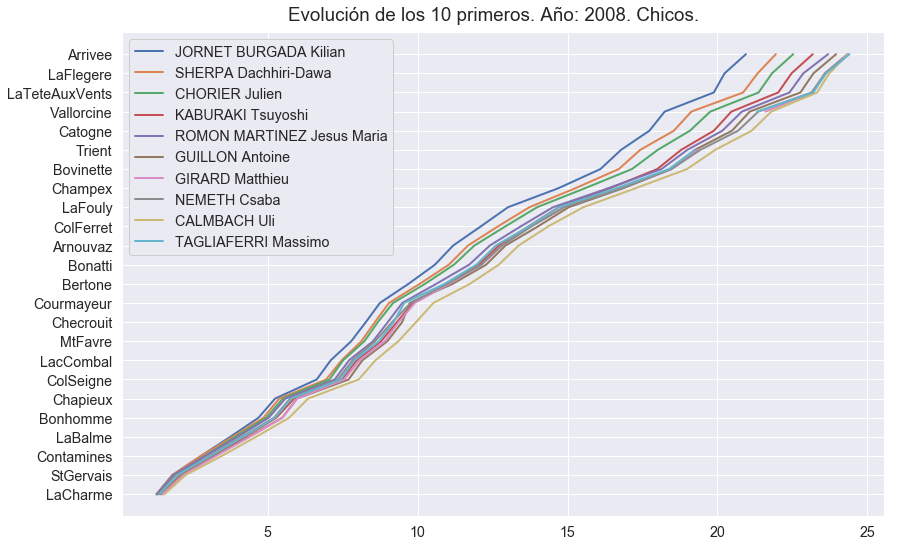

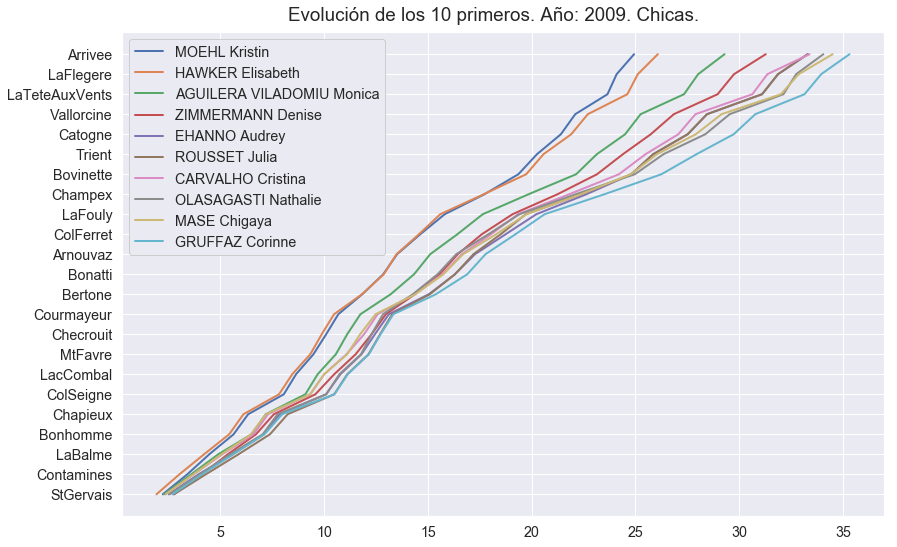

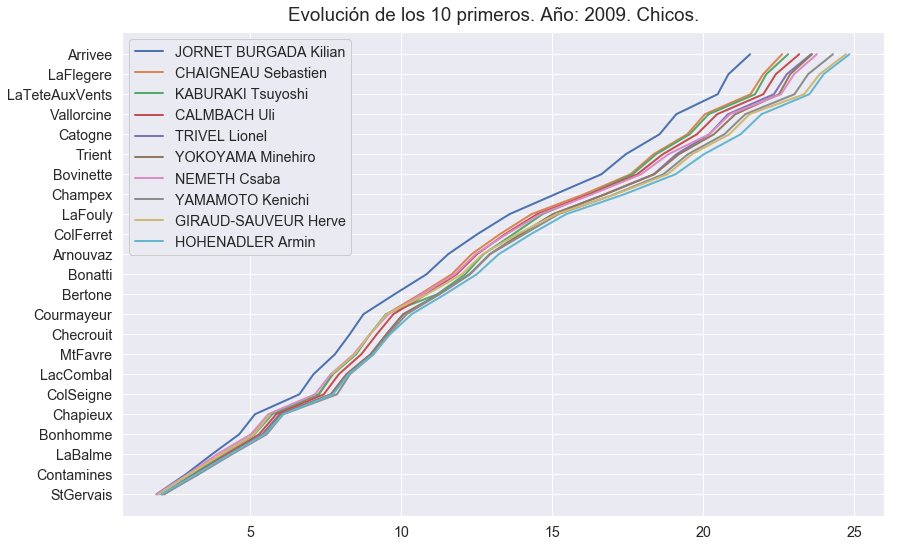

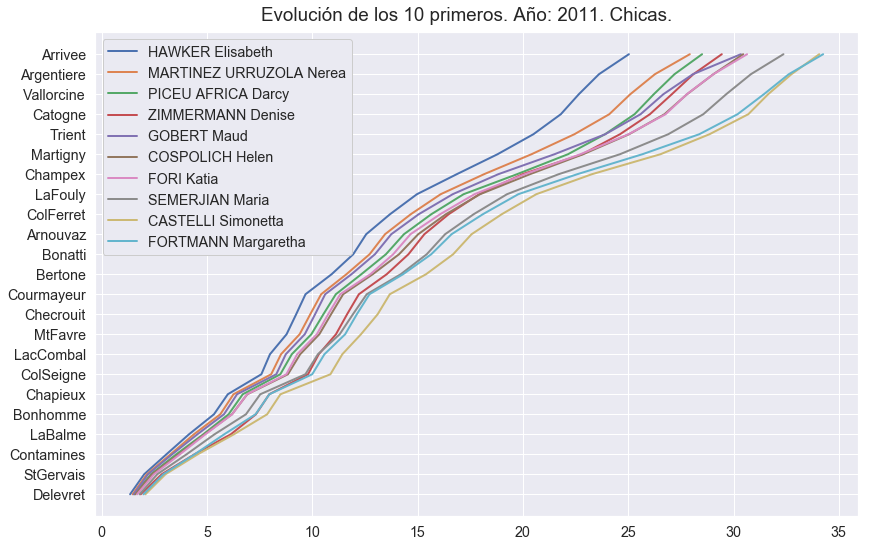

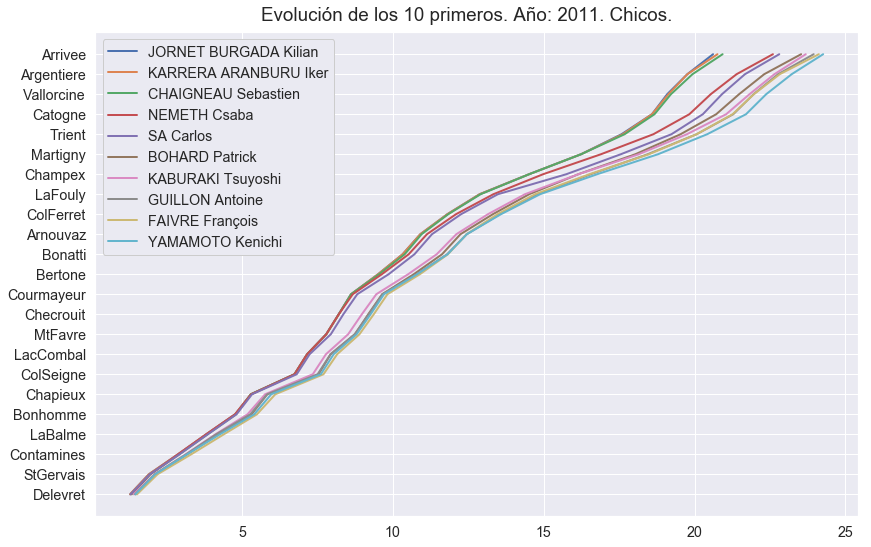

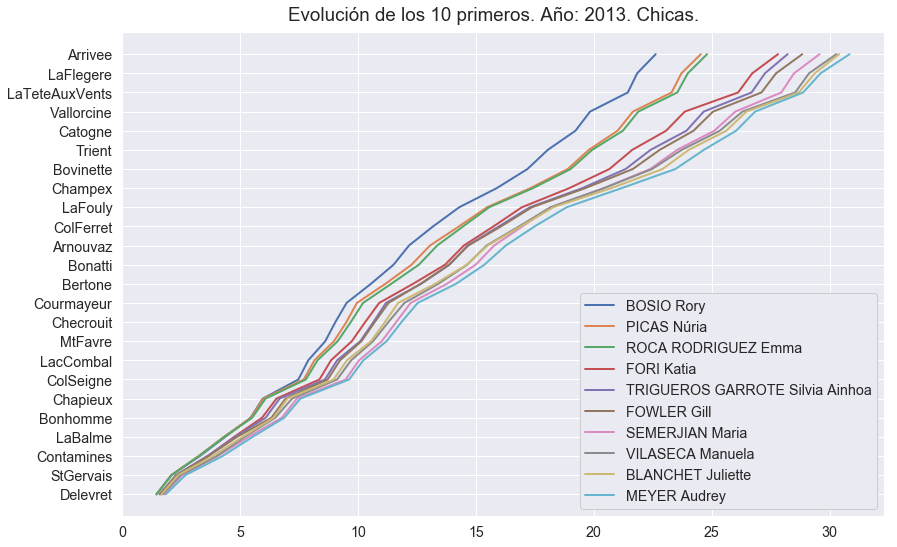

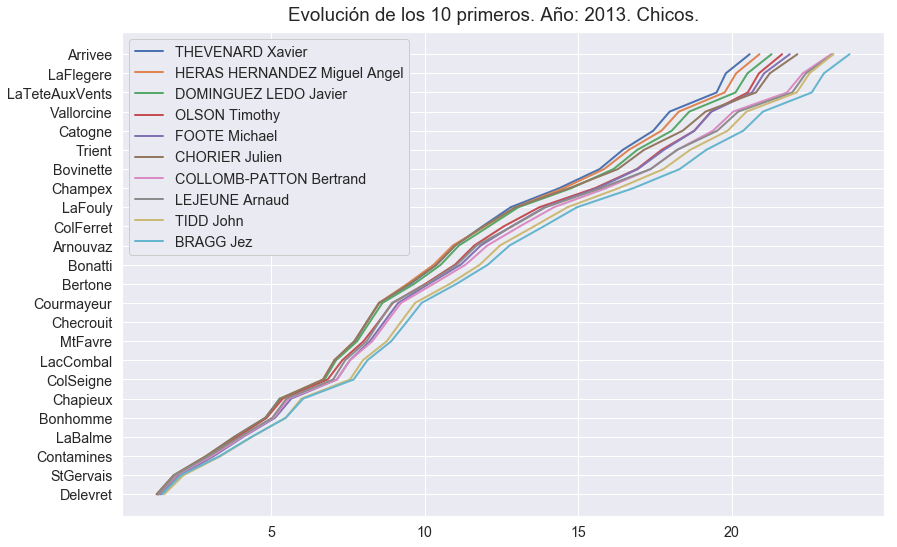

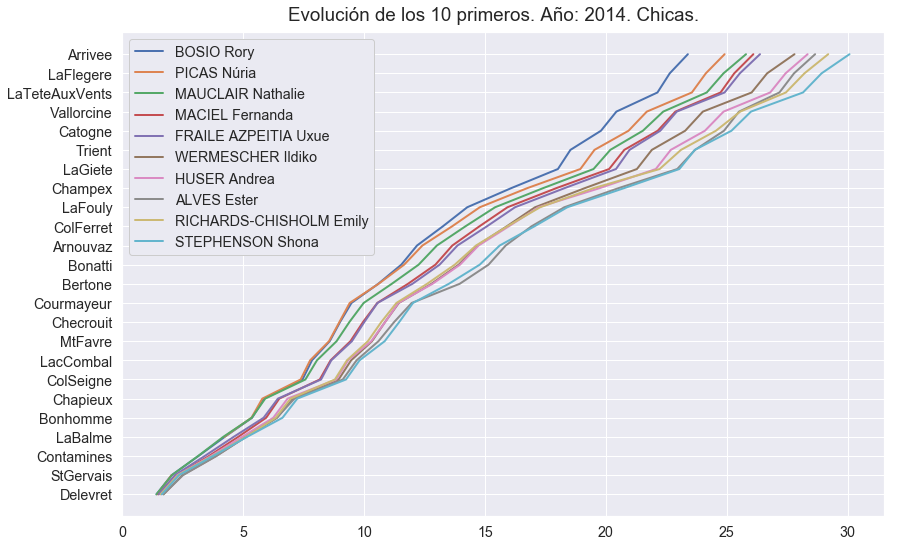

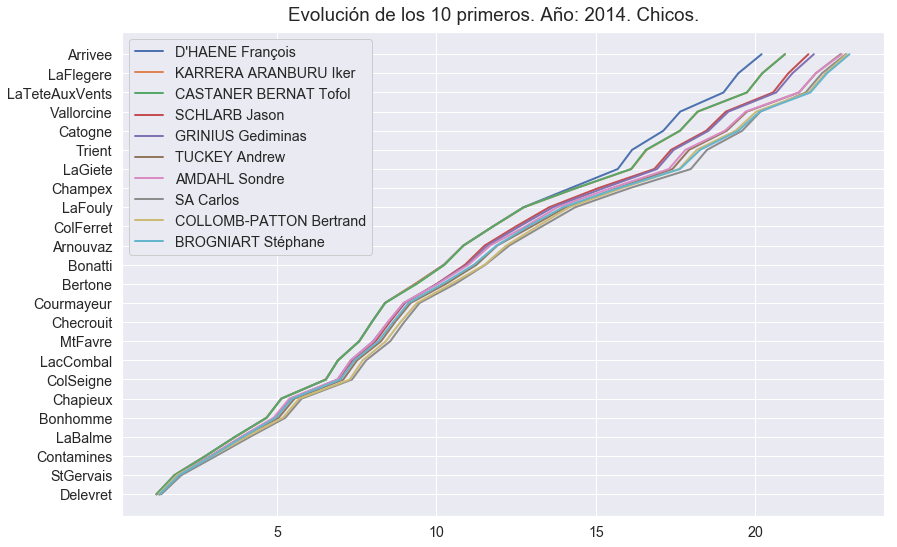

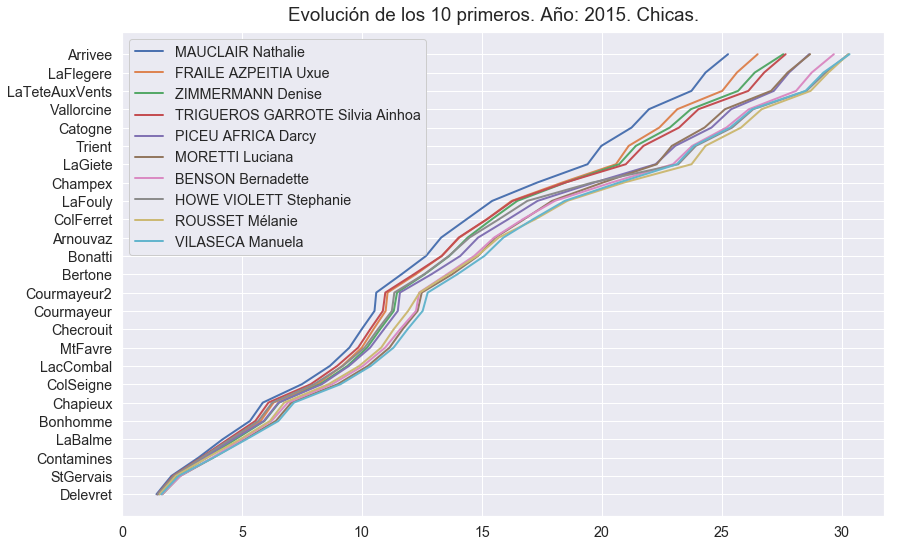

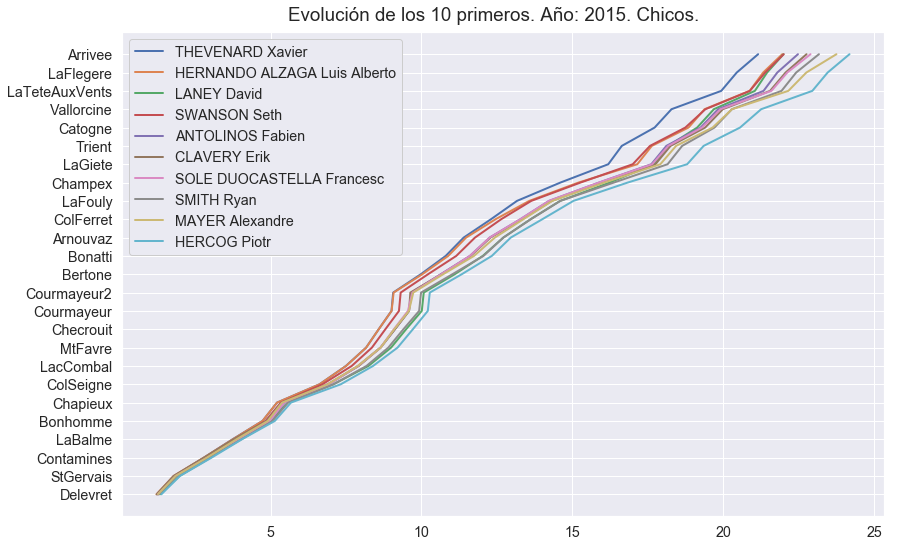

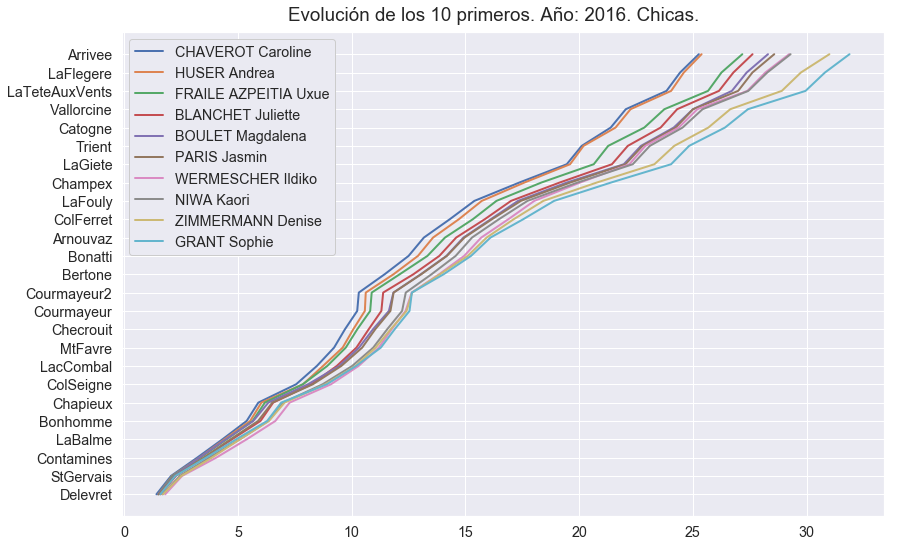

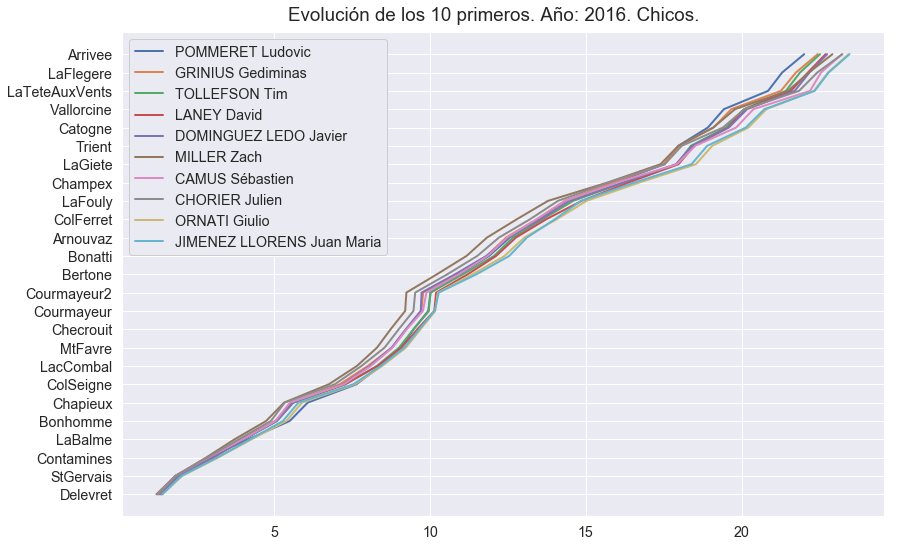

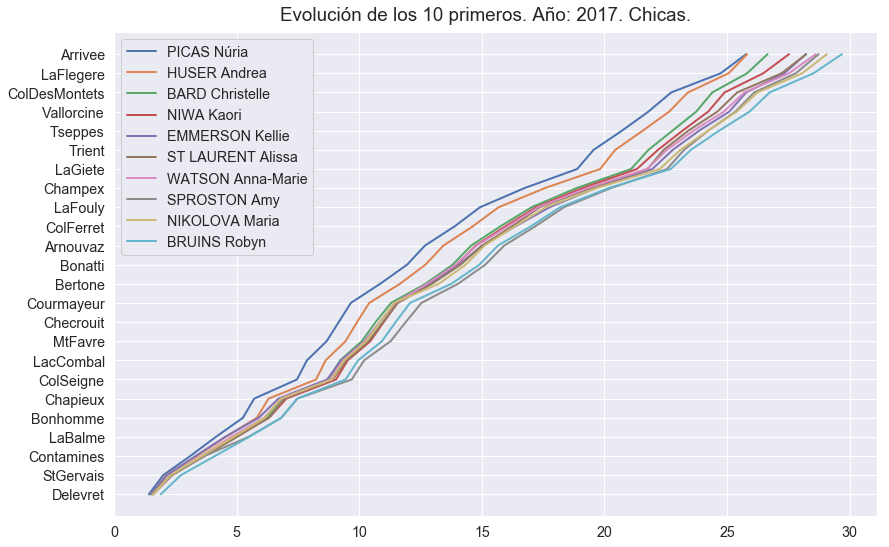

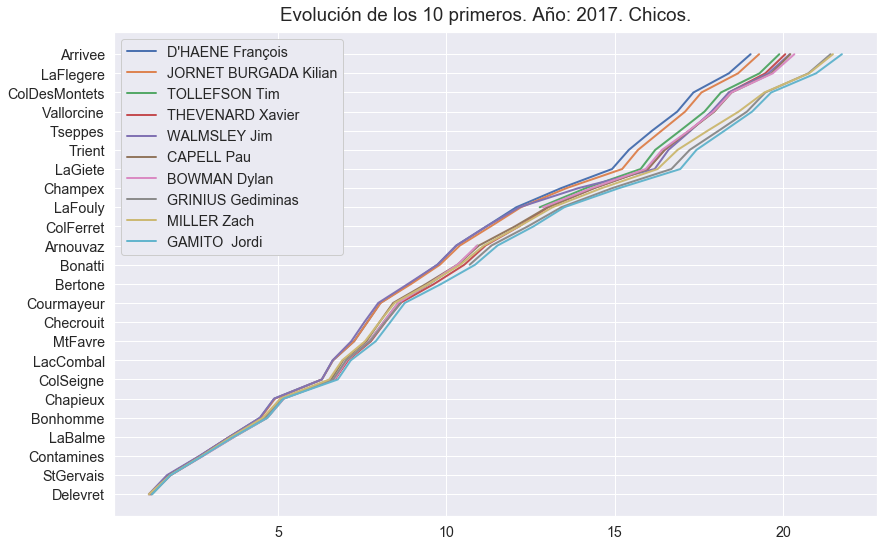

In [15]:
# funcion auxiliar para plotear los top n de cada año por sexo
# por defecto los 5 primeros sin distinción de sexo
def plot_topN(df, year, n=5, sex='all'):
    # función que recupera el año por sexo
    def get_year(df, year, sex):
        # filtra el año
        year_df = df.loc[df.Year == year]
        # si es chico o chica filtra por sexo
        if sex == 'h' or sex == 'f':
            year_df = year_df.loc[year_df.Sex == sex]
        # mask de no nans
        notnas = year_df.columns[year_df.notna().any()].tolist()
        return year_df[notnas]

    # invocamos el año
    ydf = get_year(df, year, sex)
    # importante, si hay menos registros que los pedidos recuperamos el número de registros
    n = min(ydf.shape[0], n)

    # escogemos el top n
    topN = ydf.sort_values(by='Arrivee')[:n]
    # recuperamos el nombre de las columnas de crono por posición
    cols = list(topN)[10:]
    # convertimos timedeltas a horas
    cronos = topN[cols] / np.timedelta64(1, 'h')
    # recuperamos la columna de nombres
    cronos['Name'] = topN.Name
    # la ponemos como índice del dataframe
    cronos.set_index('Name', inplace=True)

    # establecemos el tamaño de los plots y algunas configuraciones
    plt.subplots(figsize=(plot_width, plot_height))
    plt.tight_layout(pad=2)
    # creamos un array de 0 al número de puntos de paso (será el eje y)
    y = np.arange(0, len(cols))
    # recorremos cronos y hacemos un plot para cada punto de paso
    for i in np.arange(0, n):
        # en el eje x mostramos el tiempo
        x = cronos.iloc[i]
        # ponemos los nombres en el eje y
        plt.yticks(y, cols)
        plt.plot(x, y, label=x.name)
    plt.legend(framealpha=1, frameon=True)
    # montamos el título del gráfico
    fig = plt.gcf()
    if sex == 'f':
        who = 'Chicas'
    elif sex == 'h':
        who = 'Chicos'
    else:
        who = 'Chicos y chicas'
    fig.suptitle('Evolución de los ' + str(n) +
                 ' primeros. Año: ' + str(year) + '. ' + who + '.')


# mostramos los gráficos de cada años para chicas y chicos
for x in np.arange(2003, 2018):
    # 2010 no tiene llegada y 2012 no está en el dataframe
    if not (x == 2010 or x == 2012):
        plot_topN(df, x, 10, 'f')
        plot_topN(df, x, 10, 'h')


 #### **Chicos**. En 2005 se aprecian unos cuantos nulos. En 2006 hay un punto de paso sin datos y un cronometraje en Tseppes del corredor Vincent Delebarre claramente erróneo. En general se ve que la separación entre el primero y el décimo supera las tres horas, excepto en 2016 que no llega a dos horas: las líneas en la llegada están muy próximas.

 #### **Chicas**. En 2004, 2007 y 2008 también aparecen unos cuantos nulos. En este caso, la separación entre el primero y el décimo es mucho más ancha, excepto en 2016 que no llega a dos horas: las líneas en la llegada están muy próximas.